In [3]:
# Mount to Google Drive either 
# to read or write to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# I. Read data and EDA

In [4]:
# Import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [5]:
# Load training documents
print("[INFO] Loading training data ...")
docs_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)

[INFO] Loading training data ...


In [6]:
class_names = docs_train.target_names

In [7]:
# Load tesing documents
print("[INFO] Loading testing data ...")
docs_test = fetch_20newsgroups(subset='test', shuffle=True)

[INFO] Loading testing data ...


In [8]:
print("Number of category: ", len(class_names))
print("Number of train documents: ", len(docs_train.target))
print("Number of test documents: ", len(docs_test.target))
print("Categories: \n", '\n'.join(class_names))

Number of category:  20
Number of train documents:  11314
Number of test documents:  7532
Categories: 
 alt.atheism
comp.graphics
comp.os.ms-windows.misc
comp.sys.ibm.pc.hardware
comp.sys.mac.hardware
comp.windows.x
misc.forsale
rec.autos
rec.motorcycles
rec.sport.baseball
rec.sport.hockey
sci.crypt
sci.electronics
sci.med
sci.space
soc.religion.christian
talk.politics.guns
talk.politics.mideast
talk.politics.misc
talk.religion.misc


In [9]:
# Distribution of class
_, train_class_dist = np.unique(docs_train.target, return_counts=True)
_, test_class_dist = np.unique(docs_test.target, return_counts=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


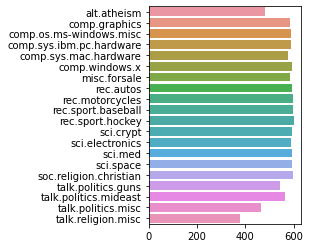

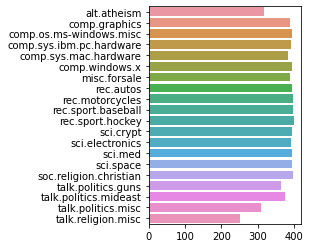

In [10]:
import seaborn as sns

plt.figure()
plt.subplot(121)
sns.barplot(train_class_dist, class_names)

plt.figure()
plt.subplot(122)
sns.barplot(test_class_dist, class_names)

In [11]:
docs_train.data[2].split('\n')[0:5]

['From: twillis@ec.ecn.purdue.edu (Thomas E Willis)',
 'Subject: PB questions...',
 'Organization: Purdue University Engineering Computer Network',
 'Distribution: usa',
 'Lines: 36']

In [12]:
docs_train.target

array([7, 4, 4, ..., 3, 1, 8])

# II. Extracting features from text files

# 1. SVM

In [13]:
pipeline_list = [('bow', CountVectorizer(stop_words='english')),
                 ('tfidf', TfidfTransformer(sublinear_tf=True, norm='l2')),
                 ('svm', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, max_iter=5, random_state=42, tol=None))]

parameters_svm = {'bow__ngram_range': [(1, 1), (1, 2)],
                  'tfidf__use_idf': (True, False),
                  'svm__alpha': (1e-2, 1e-3)}

In [14]:
# define model's pipeline 
text_clf = Pipeline(pipeline_list)
gs_text_clf = GridSearchCV(text_clf, parameters_svm, n_jobs=-1)

In [15]:
print("[INFO] training SVM model ...")
gs_text_clf.fit(docs_train.data, docs_train.target)

[INFO] training SVM model ...


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('bow',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        pr

In [16]:
gs_text_clf.best_score_
gs_text_clf.best_params_

{'bow__ngram_range': (1, 2), 'svm__alpha': 0.001, 'tfidf__use_idf': True}

In [17]:
# predict on the test documents
predicted_svm = gs_text_clf.predict(docs_test.data)

In [18]:
print("[INFO] evaluating SVM model...")
print(classification_report(predicted_svm, docs_test.target, target_names=class_names))

[INFO] evaluating SVM model...
                          precision    recall  f1-score   support

             alt.atheism       0.78      0.76      0.77       329
           comp.graphics       0.75      0.82      0.78       355
 comp.os.ms-windows.misc       0.80      0.77      0.79       409
comp.sys.ibm.pc.hardware       0.69      0.76      0.72       360
   comp.sys.mac.hardware       0.83      0.86      0.85       374
          comp.windows.x       0.80      0.87      0.84       364
            misc.forsale       0.90      0.85      0.87       416
               rec.autos       0.90      0.94      0.92       380
         rec.motorcycles       0.97      0.94      0.95       413
      rec.sport.baseball       0.93      0.91      0.92       404
        rec.sport.hockey       0.99      0.88      0.93       452
               sci.crypt       0.97      0.82      0.89       471
         sci.electronics       0.66      0.85      0.74       305
                 sci.med       0.85      0.9

# 2. Random Forest

In [19]:
# Thes best parameters for two first model 
pipeline_list = [('bow', CountVectorizer(stop_words='english', ngram_range=(1, 2))),
                 ('tfidf', TfidfTransformer(sublinear_tf=True, norm='l2')),
                 ('rf', RandomForestClassifier(n_estimators=400, max_depth=45, random_state=42))] # Chưa Grid Search tối ưu =))

In [20]:
# define model's pipeline 
text_clf = Pipeline(pipeline_list)

In [21]:
print("[INFO] training Random Forest model ...")
text_clf.fit(docs_train.data, docs_train.target)

[INFO] training Random Forest model ...


Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=45, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                  

In [22]:
predicted_rf = text_clf.predict(docs_test.data)

In [23]:
print("[INFO] evaluating Random Forest model...")
print(classification_report(predicted_rf, docs_test.target, target_names=class_names))

[INFO] evaluating Random Forest model...
                          precision    recall  f1-score   support

             alt.atheism       0.65      0.77      0.71       271
           comp.graphics       0.72      0.61      0.66       459
 comp.os.ms-windows.misc       0.79      0.68      0.73       455
comp.sys.ibm.pc.hardware       0.67      0.69      0.68       382
   comp.sys.mac.hardware       0.80      0.79      0.79       391
          comp.windows.x       0.74      0.80      0.77       369
            misc.forsale       0.89      0.71      0.79       489
               rec.autos       0.83      0.87      0.85       375
         rec.motorcycles       0.92      0.89      0.91       412
      rec.sport.baseball       0.90      0.92      0.91       388
        rec.sport.hockey       0.96      0.85      0.90       450
               sci.crypt       0.93      0.88      0.90       420
         sci.electronics       0.53      0.67      0.59       311
                 sci.med       0.7